In [397]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor 
import pre
import traceback
from sklearn import tree
from sklearn.manifold import TSNE
#import openpyxl

In [442]:
raw_df = pd.read_excel("../data/DryBeanDataSet.xlsx")
raw_df.replace("?", np.nan, inplace=True)

/var/folders/_v/wtqndz5s2cqc5nfy735t040h0000gn/T/ipykernel_98537/1585081721.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_df.replace("?", np.nan, inplace=True)


# Start with the tale for understanding the data
### Here is what I want to end up with for each attribute 
- mean 
- median
- std 
- range 
- descriptionn 
- 25% 
- 50% 
- 75% 
- amount of NaN 
- amount outside the 2.5 * IQR thing 
- min & max 
- Some type of measure of normality or skewness

### For the Class & non numeric fetas
- value counts 
- missing data in classes 
- Desciption of what these actually are and what we expect them to be 
- Maybe like a scientific discription of them and then if we expect some to be smaller then we can say that are mught be usefull 

In [443]:
# First drop all rows for which the class is null, these observations are useless


In [469]:

nan_rows = raw_df[raw_df.isna().any(axis=1)]
nan_rows.shape

(52, 22)

In [445]:
types = raw_df.dtypes

In [446]:
types['Area']

dtype('int64')

In [447]:
class_counts = raw_df['Class'].value_counts()
colour_counts = raw_df['Colour'].value_counts()

In [448]:
table = raw_df.describe()
table_inv = table.T
table_inv['range'] = table_inv['max'] - table_inv['min']

In [449]:
# Discription df intialised

# Data for the DataFrame with updated column names
data = {
    'Feature': [
        'Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
        'Eccentricity', 'ConvexArea', 'Constantness', 'EquivDiameter', 'Colour',
        'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1',
        'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4', 'ShapeFactor5', 'ShapeFactor6',
        'Class', 'Sort order'
    ],
    'Description': [
        'The area of a bean zone and the number of pixels within its boundaries.',
        'The circumference of the bean, defined as the length of its border.',
        'The distance between the ends of the longest line that can be drawn from a bean.',
        'The longest line that can be drawn from the bean while standing perpendicular to the main axis.',
        'Eccentricity of the ellipse having the same moments as the region.',
        'Number of pixels in the smallest convex polygon that can contain the area of a bean seed.',
        'NA',
        'The diameter of a circle having the same area as a bean seed area.',
        'NA',
        'The ratio of the pixels in the bounding box to the bean area.',
        'Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.',
        'Calculated with the following formula:',
        'Measures the roundness of an object.',
        'Shape Factor 1: Ratio of the major axis length to the minor axis length.',
        'Shape Factor 2: Shape factor calculated using specific formula.',
        'Shape Factor 3: Shape factor calculated using specific formula.',
        'Shape Factor 4: Shape factor calculated using specific formula.',
        'NA',
        'NA',
        'NA',
        'NA'
    ],
    'Formula': [
        'A = ∑1 (where r, c is size of region R)',
        'P = Circumference of the bean border',
        'L = Distance between the ends of the longest line that can be drawn from a bean',
        'l = Longest line perpendicular to the major axis length (L)',
        'NA',
        'C = Number of pixels in the convex hull',
        'NA',
        'Ed = sqrt(4 * A / π)',
        'NA',
        'Ex = A / AB',
        'S = C / A',
        'R = 4πA / P^2',
        'CO = Ed / sqrt(A)',
        'SF1 = L / A',
        'SF2 = Specific formula',
        'SF3 = Specific formula',
        'SF4 = Specific formula',
        'NA',
        'NA',
        'NA',
        'NA'
    ]
}

# Creating the DataFrame
df_descriptions = pd.DataFrame(data)


In [450]:
table_inv.reset_index(drop=False, inplace=True)
table_inv.rename(columns={'index': 'Feature'}, inplace=True)
desc = pd.merge(df_descriptions, table_inv, on='Feature', how='left')

In [451]:
#Removing Objects
desc_1 = desc.set_index('Feature')
desc_1 = desc_1.drop(['Colour', 'Class'])
desc_1 = desc_1.reset_index()

In [452]:
#Skewness, Kurtosis and Type
numerical_feats = desc_1['Feature']
skew = []
kurt = []
type_c = [] 
for num_feat in numerical_feats:
    s = raw_df[num_feat].skew()
    k = raw_df[num_feat].kurtosis()
    t = types[num_feat]
    skew.append(s)
    kurt.append(k)
    type_c.append(t)

desc_1['Skewness'] = skew
desc_1['Kurtosis'] = kurt
desc_1['Type'] = type_c

In [453]:
#Nan Values
desc_1 = desc_1.round(4)
desc_1['NaN values'] = 13611 - desc_1['count']
desc_1['count'] = desc_1['count'].astype(int)
desc_1['NaN values'] = desc_1['NaN values'].astype(int)

In [454]:
#Adding types
description_table_1 = desc_1[['Feature', 'Description', 'Formula', "NaN values","Type"]]
description_table_2 = desc_1[['Feature', 'mean', 'std',"25%", "50%", "75%", "range"]]
description_table_3 = desc_1[['Feature',"min", "max", "range", "Skewness", "Kurtosis"]]

In [455]:
description_table_4 =  colour_counts.to_frame().T
description_table_4['Nan Values'] = 13611 - raw_df['Colour'].count()
description_table_4 = description_table_4.T

In [462]:
description_table_5 =  class_counts.to_frame().T
description_table_5['Nan Values'] = 13611 - raw_df['Class'].count()
description_table_5 = description_table_5.T

In [463]:
#Descsription of beans
dec_of_beans = [
    'This type of dry beans, which are fuller flat, is white in color and one end is round and the other ends are round.',
    'Its seeds are small, white in color, physical structure is flat, one end is flat, and the other end is round.',
    'Large seeds, white in color, physical shape is round.',
    'Dry beans of this type are long, cylindrical, white in color and generally medium in size',
    'It is white in color, its seeds are slightly plump and slightly larger than dry beans and in shape of kidney.',
    'Beige-colored background with red stripes or variegated, speckled color, its seeds are large, physical shape is oval close to the round.',
    'It is white in color, its seeds are very big and its physical structure is oval and bulging.',
    'N/A'

]

In [465]:
description_table_5['Desc'] = dec_of_beans

In [459]:
description_table_1

,Feature,Description,Formula,NaN values,Type
0,Area,The area of a bean zone and the number of pixe...,"A = ∑1 (where r, c is size of region R)",0,int64
1,Perimeter,"The circumference of the bean, defined as the ...",P = Circumference of the bean border,0,float64
2,MajorAxisLength,The distance between the ends of the longest l...,L = Distance between the ends of the longest l...,0,float64
3,MinorAxisLength,The longest line that can be drawn from the be...,l = Longest line perpendicular to the major ax...,0,float64
4,Eccentricity,Eccentricity of the ellipse having the same mo...,NA,0,float64
5,ConvexArea,Number of pixels in the smallest convex polygo...,C = Number of pixels in the convex hull,0,int64
6,Constantness,NA,NA,0,int64
7,EquivDiameter,The diameter of a circle having the same area ...,Ed = sqrt(4 * A / π),0,float64
8,Extent,The ratio of the pixels in the bounding box to...,Ex = A / AB,6,float64
9,Solidity,Also known as convexity. The ratio of the pixe...,S = C / A,0,float64


In [389]:
description_table_2

,Feature,mean,std,25%,50%,75%,range
0,Area,53039.8926,29319.3987,36322.7500,44651.5000,61315.5000,2.341960e+05
1,Perimeter,855.2118,214.2551,703.4318,794.9405,976.9982,1.460634e+03
2,MajorAxisLength,320.1233,85.6939,253.2939,296.8800,376.4920,5.552590e+02
3,MinorAxisLength,202.2535,44.9560,175.8459,192.4269,216.9912,3.376858e+02
4,Eccentricity,0.7509,0.0920,0.7159,0.7645,0.8105,6.925000e-01
5,ConvexArea,53757.1373,29773.3641,36710.0000,45175.0000,62252.5000,2.632910e+05
6,Constantness,0.9028,0.2962,1.0000,1.0000,1.0000,1.000000e+00
7,EquivDiameter,476.5146,25853.0158,215.0525,238.4367,279.4345,3.014441e+06
8,Extent,0.7497,0.0491,0.7186,0.7599,0.7869,3.109000e-01
9,Solidity,0.9871,0.0047,0.9857,0.9883,0.9900,7.540000e-02


In [390]:
description_table_3

,Feature,min,max,range,Skewness,Kurtosis
0,Area,20420.0000,2.546160e+05,2.341960e+05,2.9547,10.8146
1,Perimeter,524.7360,1.985370e+03,1.460634e+03,1.6272,3.5943
2,MajorAxisLength,183.6012,7.388602e+02,5.552590e+02,1.3581,2.5337
3,MinorAxisLength,122.5127,4.601985e+02,3.376858e+02,2.2402,6.6641
4,Eccentricity,0.2190,9.114000e-01,6.925000e-01,-1.0627,1.3855
5,ConvexArea,-30.0000,2.632610e+05,2.632910e+05,2.9425,10.7535
6,Constantness,0.0000,1.000000e+00,1.000000e+00,-2.7203,5.4008
7,EquivDiameter,0.1614,3.014441e+06,3.014441e+06,116.5815,13592.1554
8,Extent,0.5553,8.662000e-01,3.109000e-01,-0.8964,0.6449
9,Solidity,0.9192,9.947000e-01,7.540000e-02,-2.5518,12.8160


In [466]:
description_table_4

,count
Colour,
brown,6115
black,3541
green,2023
white,1926
Nan Values,6


In [470]:
raw_df.shape

(13611, 22)

In [472]:
3542/13611

0.2602306957607817

In [467]:
description_table_5

,count,Desc
Class,,
DERMASON,3542,"This type of dry beans, which are fuller flat,..."
SIRA,2634,"Its seeds are small, white in color, physical ..."
SEKER,2025,"Large seeds, white in color, physical shape is..."
HOROZ,1927,"Dry beans of this type are long, cylindrical, ..."
CALI,1628,"It is white in color, its seeds are slightly p..."
BARBUNYA,1317,Beige-colored background with red stripes or v...
BOMBAY,521,"It is white in color, its seeds are very big a..."
Nan Values,17,N/A


In [461]:
class_counts

Class
DERMASON    3542
SIRA        2634
SEKER       2025
HOROZ       1927
CALI        1628
BARBUNYA    1317
BOMBAY       521
Name: count, dtype: int64

# Adressing the Quality Issues

In [ ]:
raw_df = raw_df.dropna(subset=['Class'])

In [300]:
# Here remove the outliers and compute if it is very big.

In [391]:
equiv = raw_df['EquivDiameter']
equiv = equiv.sort_values(ascending=False)
equiv = equiv.round(0)
equiv.head(5)

4780    3014441.0
2762      24100.0
2070        569.0
4585        566.0
1833        562.0
Name: EquivDiameter, dtype: float64

In [392]:
equiv = equiv.sort_values(ascending=True)
equiv = equiv.round(0)
equiv.head(5)

5884       0.0
3780     161.0
3824     162.0
12095    162.0
11149    163.0
Name: EquivDiameter, dtype: float64

In [303]:
convex_ares = raw_df['ConvexArea']
convex_ares = convex_ares.sort_values(ascending=True)
convex_ares.head(5)

3780     20684.0
5884     20772.0
12095    20825.0
3824     20988.0
11149    21057.0
Name: ConvexArea, dtype: float64

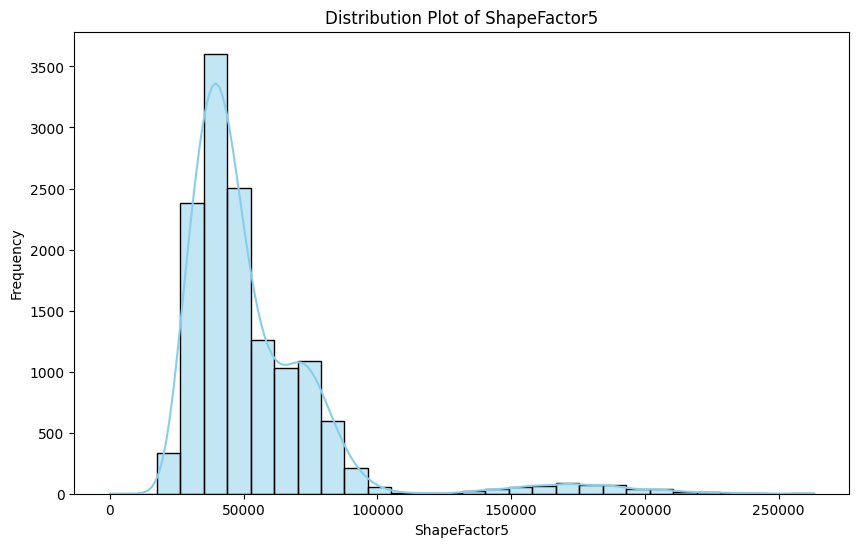

In [424]:
ShapeFac5 = raw_df['ConvexArea'].sort_values(ascending=True)

# Create a distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(ShapeFac5, kde=True, bins=30, color='skyblue')

# Add labels and title
plt.title('Distribution Plot of ShapeFactor5')
plt.xlabel('ShapeFactor5')
plt.ylabel('Frequency')

# Show the plot
plt.show()

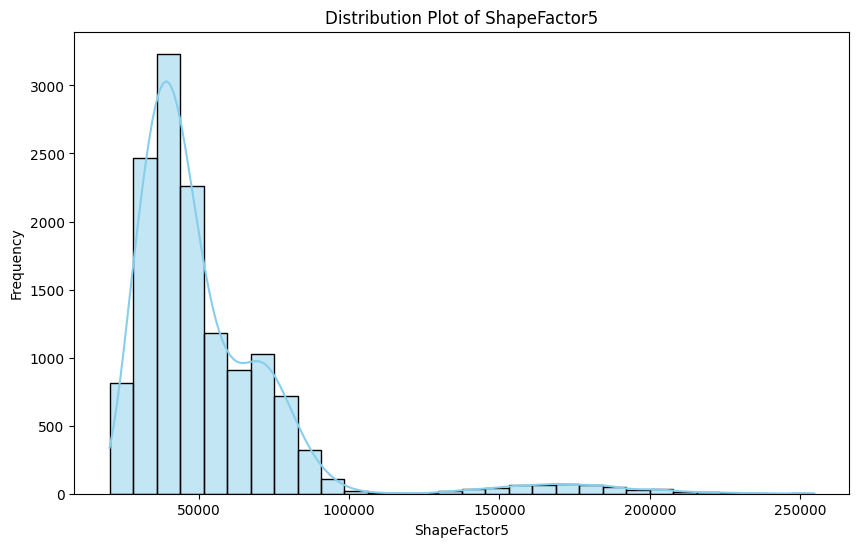

In [423]:
ShapeFac5 = raw_df['Area'].sort_values(ascending=True)

# Create a distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(ShapeFac5, kde=True, bins=30, color='skyblue')

# Add labels and title
plt.title('Distribution Plot of ShapeFactor5')
plt.xlabel('ShapeFactor5')
plt.ylabel('Frequency')

# Show the plot
plt.show()

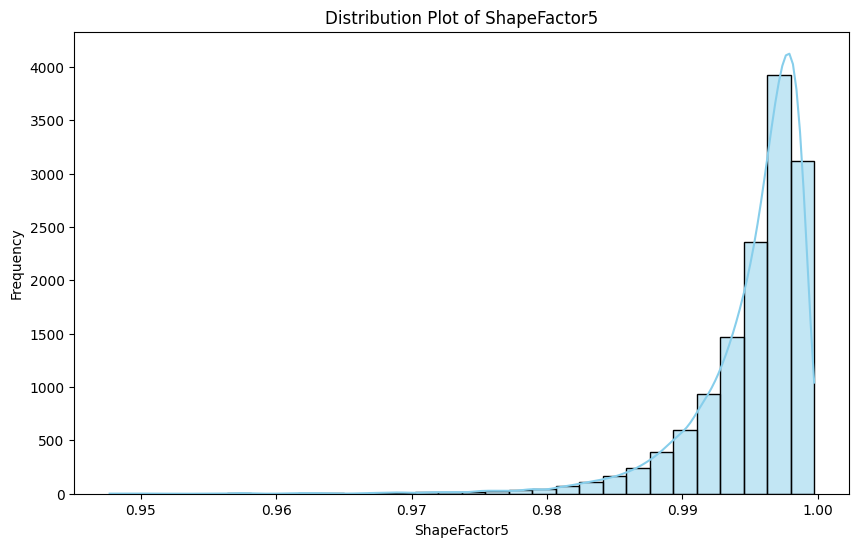

In [422]:
ShapeFac5 = raw_df['ShapeFactor5'].sort_values(ascending=True)

# Create a distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(ShapeFac5, kde=True, bins=30, color='skyblue')

# Add labels and title
plt.title('Distribution Plot of ShapeFactor5')
plt.xlabel('ShapeFactor5')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [304]:
# Only these four will be removed.
# Both the algos are robust to outliers and it is thus not neccessary to d0 anything 

In [305]:
# First we will just replace with Nan values as our KNN can handle them

In [306]:
raw_df.loc[raw_df['ConvexArea'] < 0, 'ConvexArea'] = np.nan

In [307]:
raw_df.loc[raw_df['EquivDiameter'] > 600, 'EquivDiameter'] = np.nan
raw_df.loc[raw_df['EquivDiameter'] < 100, 'EquivDiameter'] = np.nan

In [362]:
new_skew_Eq = raw_df['EquivDiameter'].skew()
new_min_Con = raw_df['ConvexArea'].min()
print("New skew value for EquivDiameter: ", new_skew_Eq)
print("New min value for ConvexArea: ", new_min_Con)

New skew value for EquivDiameter:  1.9505757016146763
New min value for ConvexArea:  20684.0


In [354]:
np.random.seed(42)
shuffled_df = raw_df.sample(frac=1).reset_index(drop=True)

dum_df = pd.get_dummies(shuffled_df, columns=['Colour'], dtype=float)

column_to_move = "Class"
features = dum_df.drop(column_to_move, axis=1)

train_size = int(dum_df.shape[0] * 0.85)
test_size = dum_df.shape[0] - train_size

train_feats = features[:train_size]
test_feats = features[train_size:]

train_class = dum_df['Class'][:train_size]
test_class = dum_df['Class'][train_size:]

tree_train = shuffled_df[:train_size] 
tree_test = shuffled_df[train_size:] 


# KNN, self implemented

In [355]:
# Creating dummy variables and test set


scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_feats)
scaled_test = scaler.transform(test_feats)

scaled_train_df = pd.DataFrame(scaled_train, columns=features.columns)
scaled_test_df = pd.DataFrame(scaled_test, columns=features.columns)

# Step 2: Add the "Class" column back to the DataFrame
scaled_train_df[column_to_move] = train_class.values

scaled_test_df[column_to_move] = test_class.values


In [356]:
K = 10
fold_size = len(scaled_train_df) // K
folds_X = [scaled_train_df[i*fold_size:(i+1)*fold_size] for i in range(K)]


In [359]:
#Variables for hyperparameter tuning
neighbors = range(3,35,2) 
distance_measures = ["manh", "euc", "cheb", "cos"]

In [360]:
def compute_masks_pre(values):
    """
    Compute masks for non-NaN values for the entire dataset.
    Returns the masks.
    """
    return ~pd.isna(values)

def make_predictions_parallel(train, test, n_neighbors, dist):
    """
    Make predictions for all test rows in parallel.
    """
    # Convert train DataFrame to NumPy arrays
    train_values = train.iloc[:, :-1].values
    train_labels = train  # Keeping labels in DataFrame for access
    train_masks = compute_masks_pre(train_values)
    
    # Convert test DataFrame to a list of rows
    test_rows = [row for _, row in test.iterrows()]
    predictions = []
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(pre.process_test_row, train_values, train_masks, train_labels, row, n_neighbors, dist) for row in test_rows]
        for future in futures:
            try:
                prediction = future.result()
                predictions.append(prediction)
            except Exception as exc:
                print(f"An error occurred: {exc}")
                print(traceback.format_exc())
    return predictions

In [367]:
accuracy = []
distance = []
number_neighbors = [] 
#actual = X_test['Class']
max_accuracy = 0
best_n = 0
best_dist = "none"
for n in neighbors:
    for measure in distance_measures:
        k_acc_mean = []
        for k in range(K):
            fold_pred = folds_X[k]
            folds_train = pd.concat([folds_X[j] for j in range(K) if j != k], axis=0)
            actual = fold_pred['Class']
            predictions = make_predictions_parallel(folds_train, fold_pred, n, measure)
            acc = accuracy_score(actual.tolist(), predictions)
            k_acc_mean.append(acc)
        print(measure)
        mean_acc = np.mean(k_acc_mean)
        accuracy.append(mean_acc)
        distance.append(measure)
        number_neighbors.append(n)

        if (mean_acc >= max_accuracy):
            max_accuracy = mean_acc
            best_n = n
            best_dist = measure
    print("DONE with: ", n)
    print(max_accuracy)



manh
euc
cheb
cos
DONE with:  3
0.9795670995670994
manh
euc
cheb
cos
DONE with:  5
0.9799134199134197
manh
euc
cheb
cos
DONE with:  7
0.9804329004329005
manh
euc
cheb
cos
DONE with:  9
0.9808658008658009
manh
euc
cheb
cos
DONE with:  11
0.9815584415584414
manh
euc
cheb
cos
DONE with:  13
0.9815584415584414
manh
euc
cheb
cos
DONE with:  15
0.9815584415584414
manh
euc
cheb
cos
DONE with:  17
0.9815584415584414
manh
euc
cheb
cos
DONE with:  19
0.9815584415584414
manh
euc
cheb
cos
DONE with:  21
0.9815584415584414
manh
euc
cheb
cos
DONE with:  23
0.9815584415584414
manh
euc
cheb
cos
DONE with:  25
0.9815584415584414
manh
euc
cheb
cos
DONE with:  27
0.9815584415584414
manh
euc
cheb
cos
DONE with:  29
0.9815584415584414
manh
euc
cheb
cos
DONE with:  31
0.9815584415584414
manh
euc
cheb
cos
DONE with:  33
0.9815584415584414


In [479]:
max_accuracy

np.float64(0.9815584415584414)

In [480]:
res = pd.DataFrame({"Acc" : accuracy, "Neig" : number_neighbors, "Dis" : distance})
res

,Acc,Neig,Dis
0,0.979567,3,manh
1,0.979048,3,euc
2,0.969697,3,cheb
3,0.979048,3,cos
4,0.979913,5,manh
...,...,...,...
59,0.979481,31,cos
60,0.978874,33,manh
61,0.978961,33,euc
62,0.965455,33,cheb


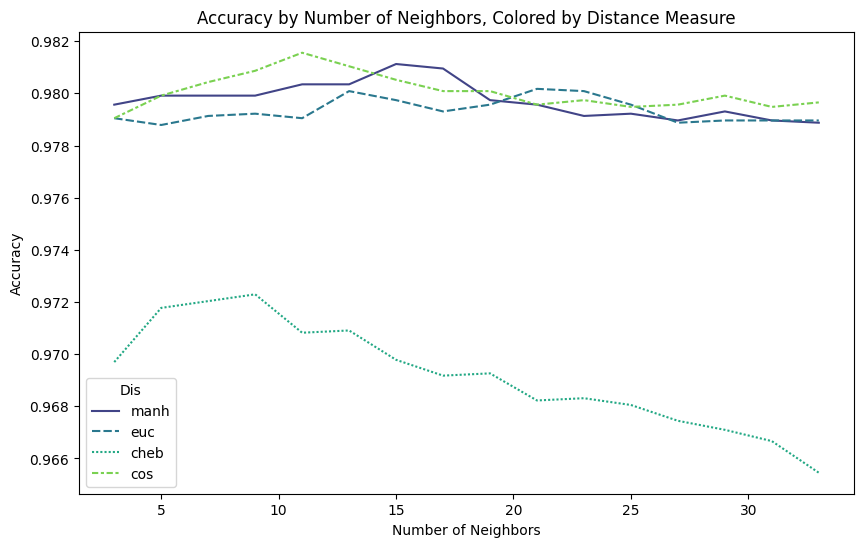

In [369]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=res, x='Neig', y='Acc', hue='Dis', palette='viridis', style='Dis')

# Add labels and title
plt.title('Accuracy by Number of Neighbors, Colored by Distance Measure')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

# Show plot
plt.show()

In [481]:
res.to_csv("Results.csv")

In [484]:
#Variables for hyperparameter tuning
neighbors = range(11,35,100) 
distance_measures = ["cos"]

In [485]:
accuracy = []
distance = []
number_neighbors = [] 
#actual = X_test['Class']
max_accuracy = 0
best_n = 0
best_dist = "none"
for n in neighbors:
    for measure in distance_measures:
        k_acc_mean = []
        for k in range(K):
            fold_pred = folds_X[k]
            folds_train = pd.concat([folds_X[j] for j in range(K) if j != k], axis=0)
            actual = fold_pred['Class']
            predictions = make_predictions_parallel(folds_train, fold_pred, n, measure)
            acc = accuracy_score(actual.tolist(), predictions)
            k_acc_mean.append(acc)
            print(acc)
        print(measure)
        mean_acc = np.mean(k_acc_mean)
        accuracy.append(mean_acc)
        distance.append(measure)
        number_neighbors.append(n)
        print(accuracy)

        if (mean_acc >= max_accuracy):
            max_accuracy = mean_acc
            best_n = n
            best_dist = measure
    print("DONE with: ", n)
    print(max_accuracy)


0.9757575757575757
0.9826839826839827
0.9809523809523809
0.9861471861471861
0.9878787878787879
0.9818181818181818
0.9774891774891775
0.9783549783549783
0.9818181818181818
0.9826839826839827
cos
[np.float64(0.9815584415584414)]
DONE with:  11
0.9815584415584414


In [486]:
k_acc_mean

[0.9757575757575757,
 0.9826839826839827,
 0.9809523809523809,
 0.9861471861471861,
 0.9878787878787879,
 0.9818181818181818,
 0.9774891774891775,
 0.9783549783549783,
 0.9818181818181818,
 0.9826839826839827]

In [487]:
np.std(k_acc_mean)

np.float64(0.0035286032679333152)

In [ ]:
scaled_test_df

In [503]:
actual = scaled_test_df['Class']
predictions = make_predictions_parallel(scaled_train_df, scaled_test_df, 11, 'cos')
accuracy_score(actual.tolist(), predictions)

0.9799019607843137

# Decision Trees simply using sklearn
- Since I will not be implementing this on my own I have to address 
- Nan values (Either imputing, calculating myself or simply dropping)
- Class Imbalance (SMOTE, tomek links)


on my own 

# Dealing with NaN values 
### For this experiment we will assume that we don't have the formulas of the columns
### So we can't just compute the missing values 

So we have to do something with them 


In [361]:
columns_with_nan = shuffled_df.columns[shuffled_df.isna().any()].tolist()

# Print columns with missing values
print(columns_with_nan)

['ConvexArea', 'EquivDiameter', 'Colour', 'Extent', 'Compactness', 'ShapeFactor6']


In [316]:
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB_Self
from sklearn.metrics import mean_squared_error

In [476]:
def iterative_imputer(df, max_iter=100, tol=1e-7, verbose=False):
    df_filled = df.copy()
    # Initial mean imputation for starting the iterations
    for col in df.columns:
        if df[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df[col]):
                df_filled[col] = df_filled[col].fillna(df[col].mean())
            else:
                df_filled[col] = df_filled[col].fillna(df[col].mode())
    
    for iteration in range(max_iter):
        print(iteration)
        df_previous = df_filled.copy()
        if verbose:
            print(f"Iteration {iteration + 1}")
        
        # Impute each column with missing values using a regression model
        for col in df.columns:
            if df[col].isnull().any():
                missing_mask = df[col].isnull()
                not_missing_mask = ~missing_mask
                df_dum = pd.get_dummies(df_filled.drop(columns=col))
                df_dum[col] = df_filled[col]
                # Define the features and target
                X_train = df_dum.loc[not_missing_mask].drop(columns=col)
                y_train = df_dum.loc[not_missing_mask, col]
                X_missing = df_dum.loc[missing_mask].drop(columns=col)
                if pd.api.types.is_numeric_dtype(df[col]):
                    # Use Linear Regression for numeric data
                    model = LinearRegression()
                else:
                # Use Logistic Regression for categorical data
                    model = CategoricalNB()
                model.fit(X_train, y_train)
                
                # Predict the missing values
                df_filled.loc[missing_mask, col] = model.predict(X_missing)
        
        # Check for convergence
        #change = np.sqrt(mean_squared_error(df_previous.fillna(0), df_filled.fillna(0)))

        # Calculate change for numeric and categorical separately
        numeric_cols = df.select_dtypes(include='number').columns
        categorical_cols = df.select_dtypes(include='object').columns

        # Calculate the mean squared error for numeric columns
        if len(numeric_cols) > 0:
            mse = mean_squared_error(df_previous[numeric_cols].fillna(0), df_filled[numeric_cols].fillna(0))
        else:
            mse = 0

        # Calculate the proportion of differing values for categorical columns
        if len(categorical_cols) > 0:
            cat_change = (df_previous[categorical_cols] != df_filled[categorical_cols]).sum().sum() / df_filled[categorical_cols].size
        else:
            cat_change = 0

        # Combine both changes into a single metric
        change = np.sqrt(mse) + cat_change
        print(change)
        if verbose:
            print(f"Change: {change}")
        if change < tol:
            break
            
    return df_filled

In [490]:
tree_train = shuffled_df[:train_size] 
tree_test = shuffled_df[train_size:] 

tree_train_Y = tree_train['Class']
tree_train_X = tree_train.drop('Class', axis = 1)



tree_test_Y = tree_test['Class']
tree_test_X = tree_test.drop('Class', axis = 1)


tree_train_X_POO = iterative_imputer(tree_train_X)
tree_test_X_POO = iterative_imputer(tree_test_X)

0
41.54517610240442
1
0.09383972944961916
2
6.587896115056381e-07
3
1.8435557337294376e-10
0
0.012889394150565834
1
4.645138829457699e-08


In [491]:
tree_train = shuffled_df[:train_size] 
tree_test = shuffled_df[train_size:] 

tree_train_Y = tree_train['Class']
tree_train_X = tree_train.drop('Class', axis = 1)



tree_test_Y = tree_test['Class']
tree_test_X = tree_test.drop('Class', axis = 1)


tree_train_X = iterative_imputer(tree_train_X)
tree_test_X = iterative_imputer(tree_test_X)

0
41.54517610240442
1
0.09383972944961916
2
6.587896115056381e-07
3
1.8435557337294376e-10
0
0.012889394150565834
1
4.645138829457699e-08


In [492]:
tree_train_X = pd.get_dummies(tree_train_X, columns=['Colour'], dtype=float)
tree_test_X = pd.get_dummies(tree_test_X, columns=['Colour'], dtype=float)

In [493]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(tree_train_X, tree_train_Y)
pred = clf.predict(tree_test_X)
accuracy_score(tree_test_Y, pred)

0.9789215686274509

In [330]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [352]:
param_grid = {
    'criterion': ['gini', 'entropy','log_loss'],
    'max_depth': range(3,50),
    'min_samples_split': range(2, 9),
    'min_samples_leaf': range(2, 9),
    'class_weight' : ['balanced']
}

model = tree.DecisionTreeClassifier()
# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1)


In [353]:
grid_search.fit(tree_train_X, tree_train_Y)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print(f'Best Parameters: {best_params}')

# Make predictions with the best model
y_pred = best_model.predict(tree_test_X)

# Evaluate the model
accuracy = accuracy_score(tree_test_Y, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Fitting 10 folds for each of 6909 candidates, totalling 69090 fits
Best Parameters: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 2}
Accuracy: 0.98


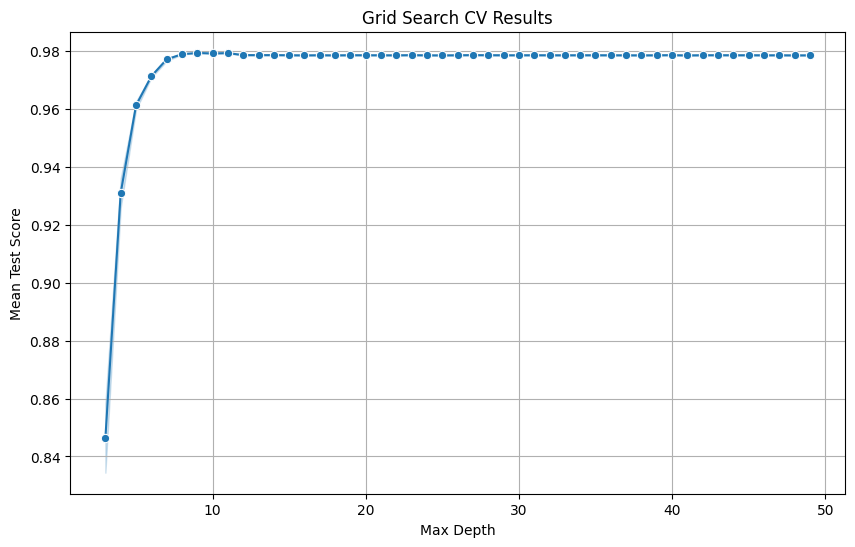

In [371]:
pee_pee = pd.DataFrame(grid_search.cv_results_)

# Display the top rows to see the structure

# Sort the DataFrame by mean test score (or another metric of interest)
pee_pee = pee_pee.sort_values(by='mean_test_score', ascending=False)

# Plot the mean test score against different hyperparameters
plt.figure(figsize=(10, 6))

# Example plot for max_depth vs. mean test score
sns.lineplot(data=pee_pee, x='param_max_depth', y='mean_test_score', marker='o')
plt.title('Grid Search CV Results')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.show()

In [494]:
model = tree.DecisionTreeClassifier(criterion= 'log_loss', max_depth=9,min_samples_leaf=8,min_samples_split=2, class_weight='balanced')
param_grid = {
    'criterion': ['log_loss'],
    'max_depth': [9],
    'min_samples_split': [8],
    'min_samples_leaf': [2],
    'class_weight' : ['balanced']
}

model = tree.DecisionTreeClassifier()
# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1)

grid_search.fit(tree_train_X, tree_train_Y)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [495]:

# Print the best parameters
print(f'Best Parameters: {best_params}')

# Make predictions with the best model
y_pred = best_model.predict(tree_test_X)

# Evaluate the model
accuracy = accuracy_score(tree_test_Y, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Best Parameters: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 8}
Accuracy: 0.98


In [500]:
cv_results = grid_search.cv_results_
tree_acc =[]
# Display fold performance for each parameter setting
for i in range(len(cv_results['params'])):
    print(f"Parameter setting {cv_results['params'][i]}")
    for j in range(grid_search.cv):
        print(f"  Fold {j + 1} test score: {cv_results['split' + str(j) + '_test_score'][i]}")
        tree_acc.append(cv_results['split' + str(j) + '_test_score'][i])
    print(f"  Mean test score: {cv_results['mean_test_score'][i]}")
    print(f"  Std test score: {cv_results['std_test_score'][i]}")
    print("-" * 50)

Parameter setting {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 8}
  Fold 1 test score: 0.976643598615917
  Fold 2 test score: 0.9826989619377162
  Fold 3 test score: 0.9826989619377162
  Fold 4 test score: 0.9809688581314879
  Fold 5 test score: 0.9852813852813853
  Fold 6 test score: 0.9688311688311688
  Fold 7 test score: 0.9826839826839827
  Fold 8 test score: 0.9800865800865801
  Fold 9 test score: 0.9792207792207792
  Fold 10 test score: 0.9783549783549783
  Mean test score: 0.9797469255081712
  Std test score: 0.004350779251942359
--------------------------------------------------


In [502]:
np.std(tree_acc)

np.float64(0.004350779251942359)

In [412]:
scaler = StandardScaler()
poo = scaler.fit_transform(raw_df.drop(columns=['Class', 'Colour']).dropna())

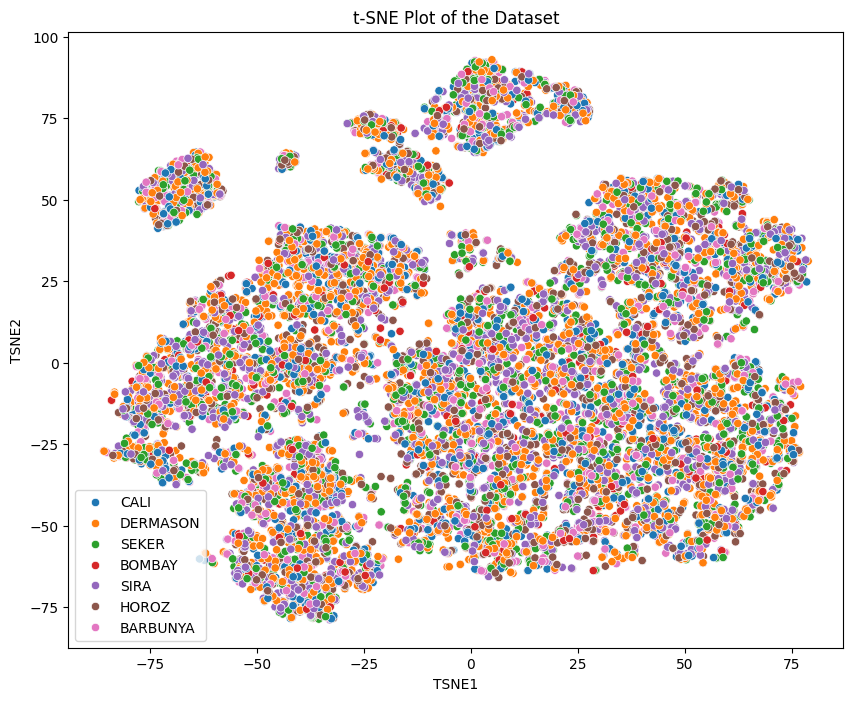

In [413]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(poo)

# Step 4: Create a DataFrame with t-SNE results and the target variable 'Class'
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Class'] = raw_df['Class']

# Step 5: Plot the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Class', data=df_tsne, palette='tab10')
plt.title('t-SNE Plot of the Dataset')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend(loc='best')
plt.show()

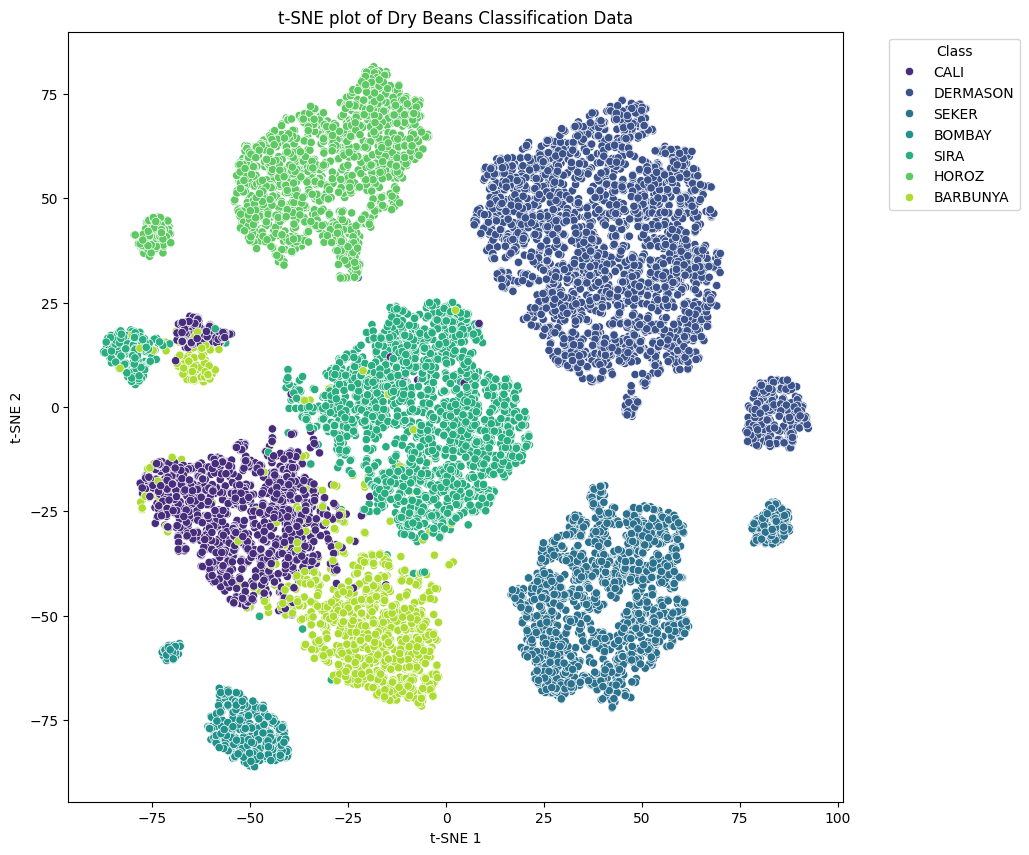

In [506]:
# t-SNE plot of the data

df_tsne = raw_df.dropna()

# Separate features and labels
X = df_tsne.drop(columns=['Class'])  # Assuming 'Class' is the column with the labels
X = pd.get_dummies(X)

y = df_tsne['Class']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Create a DataFrame with t-SNE results and labels
tsne_df = pd.DataFrame(data=X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tsne_df['Class'] = y.values

# Plot with Seaborn
plt.figure(figsize=(10, 10))
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='Class', palette='viridis', data=tsne_df)
plt.title("t-SNE plot of Dry Beans Classification Data")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("TSNE.pdf", bbox_inches='tight')
plt.show()

In [478]:
for i in range(3,35,2):
    print(i)

3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
